<img src = "https://github.com/barcelonagse-datascience/academic_files/raw/master/bgsedsc_0.jpg">
$\newcommand{\bb}{\boldsymbol{\beta}}$
$\DeclareMathOperator{\Gau}{\mathcal{N}}$
$\newcommand{\bphi}{\boldsymbol \phi}$
$\newcommand{\bx}{\boldsymbol{x}}$
$\newcommand{\bu}{\boldsymbol{u}}$
$\newcommand{\by}{\boldsymbol{y}}$
$\newcommand{\whbb}{\widehat{\bb}}$
$\newcommand{\hf}{\hat{f}}$
$\newcommand{\tf}{\tilde{f}}$
$\newcommand{\ybar}{\overline{y}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\Var}{Var}$
$\newcommand{\Cov}{Cov}$
$\newcommand{\Cor}{Cor}$

## Customer Churn Analysis and Classification

With the rapid development of telecommunication industry, the service providers are inclined more towards expansion of the subscriber base. To meet the need of surviving in the competitive environment, the retention of existing customers has become a huge challenge. It is stated that the cost of acquiring a new customer is far more than that for retaining the existing one. Therefore, it is imperative for the telecom industries to use advanced analytics to understand consumer behavior and in-turn predict the association of the customers as whether or not they will leave the company.

You are given a dataset: each row represents a customer and each column contains attributes related to customer as described:

+ Churn (target): 1 if customer cancelled service, 0 if not
+ AccountWeeks: number of weeks customer has had active account
+ ContractRenewal: 1 if customer recently renewed contract, 0 if not
+ DataPlan: 1 if customer has data plan, 0 if not
+ DataUsage: gigabytes of monthly data usage
+ CustServCalls: number of calls into customer service
+ DayMins: average daytime minutes per month
+ DayCalls: average number of daytime calls
+ MonthlyCharge: average monthly bill
+ OverageFee: largest overage fee in last 12 months
+ RoamMins: average number of roaming minutes


You are asked to **develop an algorithm** to be able to assess which are the customers that have the highest probability to churn. Besides that you will be asked to answer the 3 following questions:

1. **What variables are contributing to customer churn?** 
2. **Who are the customers more likely to churn?**
3. **What actions can be taken to stop them from leaving?**


You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Create extra variables if needed/possible
3. *Build* your model and test it on the same input data
4. Assess expected accuracy using *cross-validation*
5. Tune the hyperparameters of your model
6. Repeat steps 4 and 5 until you find the best model possible
7. Answer the questions asked

## Main criteria for grading
+ Algorithm implemented
+ AUC score given
+ At least Random Forest and Xgboost are used
+ Data preparation and exploration
+ Hyperparameter optimization 
+ Cross-validation used
+ Code is combined with neat and understandable commentary, with some titles and comments 

In [147]:
# import libraries
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import *
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_text
import random

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(suppress=True)


### Step 1. *Explore* and understand the dataset. 

In [2]:
# read data
df = pd.read_csv('churn_data.csv', sep=';')

In [3]:
df.head()

Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
0      0           128                1         1       2.70              1   
1      0           107                1         1       3.70              1   
2      0           137                1         0       0.00              0   
3      0            84                0         0       0.00              2   
4      0            75                0         0       0.00              3   

   DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
0   265.10       110          89.00        9.87     10.00  
1   161.60       123          82.00        9.78     13.70  
2   243.40       114          52.00        6.06     12.20  
3   299.40        71          57.00        3.10      6.60  
4   166.70       113          41.00        7.42     10.10

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


In [5]:
df.describe()

Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  \
count 3333.00       3333.00          3333.00   3333.00    3333.00   
mean     0.14        101.06             0.90      0.28       0.82   
std      0.35         39.82             0.30      0.45       1.27   
min      0.00          1.00             0.00      0.00       0.00   
25%      0.00         74.00             1.00      0.00       0.00   
50%      0.00        101.00             1.00      0.00       0.00   
75%      0.00        127.00             1.00      1.00       1.78   
max      1.00        243.00             1.00      1.00       5.40   

       CustServCalls  DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
count        3333.00  3333.00   3333.00        3333.00     3333.00   3333.00  
mean            1.56   179.78    100.44          56.31       10.05     10.24  
std             1.32    54.47     20.07          16.43        2.54      2.79  
min             0.00     0.00      0.00          14.00        0.00      0.00  
25%             1.00   143.70     87.00          45.00        8.33      8.50  
50%             1.00   179.40    101.00          53.50       10.07     10.30  
75%             2.00   216.40    114.00          66.20       11.77     12.10  
max             9.00   350.80    165.00         111.30       18.19     20.00

In [6]:
churn_count_df = df.Churn.value_counts().reset_index().rename(columns={'Churn': 'Count', 'index': 'Churn'})
churn_count_df.Churn = churn_count_df.Churn.astype(object)

In [7]:
fig = px.bar(churn_count_df, x="Churn", y="Count", color='Churn', title="Customer Churn")
fig.show()

Based on barplot above we can observe that 483 customers have churned from total customer base of 3333, which is around 14.5%. Although data is imbalanced still the propotion is not too critical and we can balance it in order to get better performance.


### Step 2. Create extra variables if needed/possible


In [8]:
# define feature and target objects
X = df.drop(columns=['Churn'])
y = df.Churn

##### There is no specific need to standardize or normalize data for decision tree models, however we can think of some features to be included in the model like dummy variables for several numerical variables by defining cutoff values. However, choosing cutoff values would not be easy task and current accuracy is sufficient for this task.

### Step 3. *Build* your model and test it on the same input data

#### For this project we examined the data using 3 models: Decision Tree Classifer, Random Forest Classifier, and XGBoost.

## Decision Tree Classifier

In [10]:
# train the model using DecisionTree classifier
clf_tree = DecisionTreeClassifier(max_depth=4, random_state=1)
clf_tree.fit(X, y)

# predict test set labels
y_pred_dt = clf_tree.predict(X)

In [11]:
print('AUC Decision Tree: ', roc_auc_score(y, y_pred_dt))

AUC Decision Tree:  0.7804511278195488


In [12]:
print('Accuracy Score Decision Tree: ', accuracy_score(y, y_pred_dt))

Accuracy Score Decision Tree:  0.9288928892889289


In [13]:
print(classification_report(y, y_pred_dt))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2850
           1       0.90      0.57      0.70       483

    accuracy                           0.93      3333
   macro avg       0.92      0.78      0.83      3333
weighted avg       0.93      0.93      0.92      3333



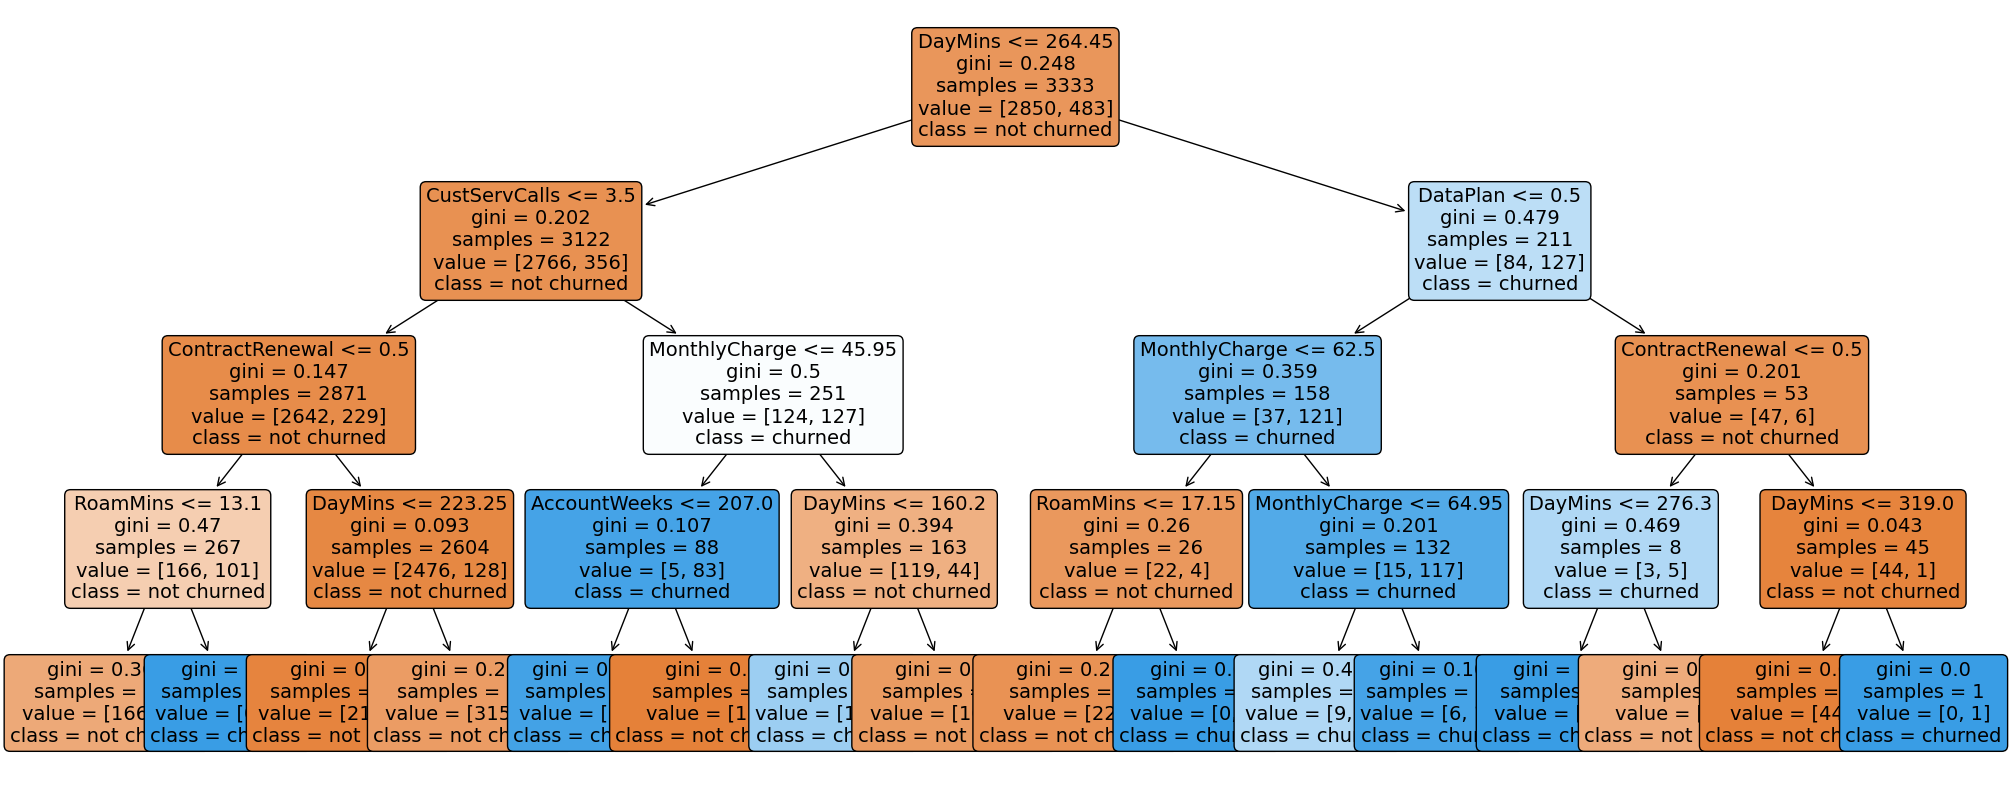

In [14]:
from sklearn.tree import plot_tree
plt.figure(figsize=(25,10))
plot_iris = plot_tree(clf_tree,
                      feature_names=X.columns.tolist(), 
                      class_names=['not churned', 'churned'], 
                      filled=True, 
                      rounded=True, 
                      fontsize=14)

## Random Forest Classifier

In [15]:
# Instantiate rf
rf = RandomForestClassifier(max_depth=9, random_state=0)
             
# Fit rf to the training set    
rf.fit(X, y) 
 
# Predict test set labels
y_pred_rf = rf.predict(X)

In [16]:
print('AUC Random Forest: ', roc_auc_score(y, y_pred_rf))

AUC Random Forest:  0.8856020485997602


In [17]:
print('Accuracy Score: ', accuracy_score(y, y_pred_rf))

Accuracy Score:  0.9660966096609661


In [18]:
print(classification_report(y, y_pred_rf))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2850
           1       0.99      0.77      0.87       483

    accuracy                           0.97      3333
   macro avg       0.98      0.89      0.92      3333
weighted avg       0.97      0.97      0.96      3333



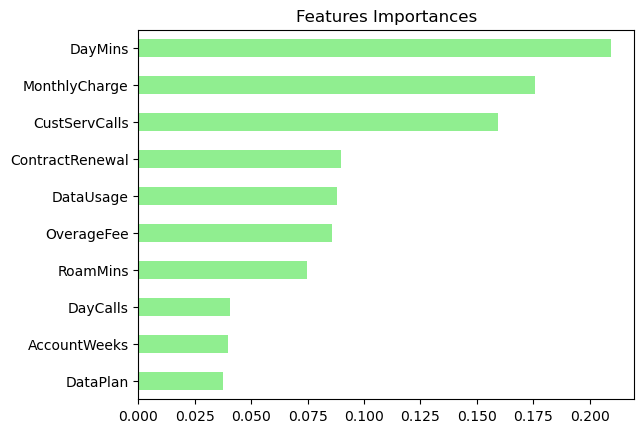

In [19]:
# Create a pd.Series of features importances
importances = pd.Series(data=rf.feature_importances_,
                        index= X.columns.tolist())
 
# Sort importances
importances_sorted = importances.sort_values()
 
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

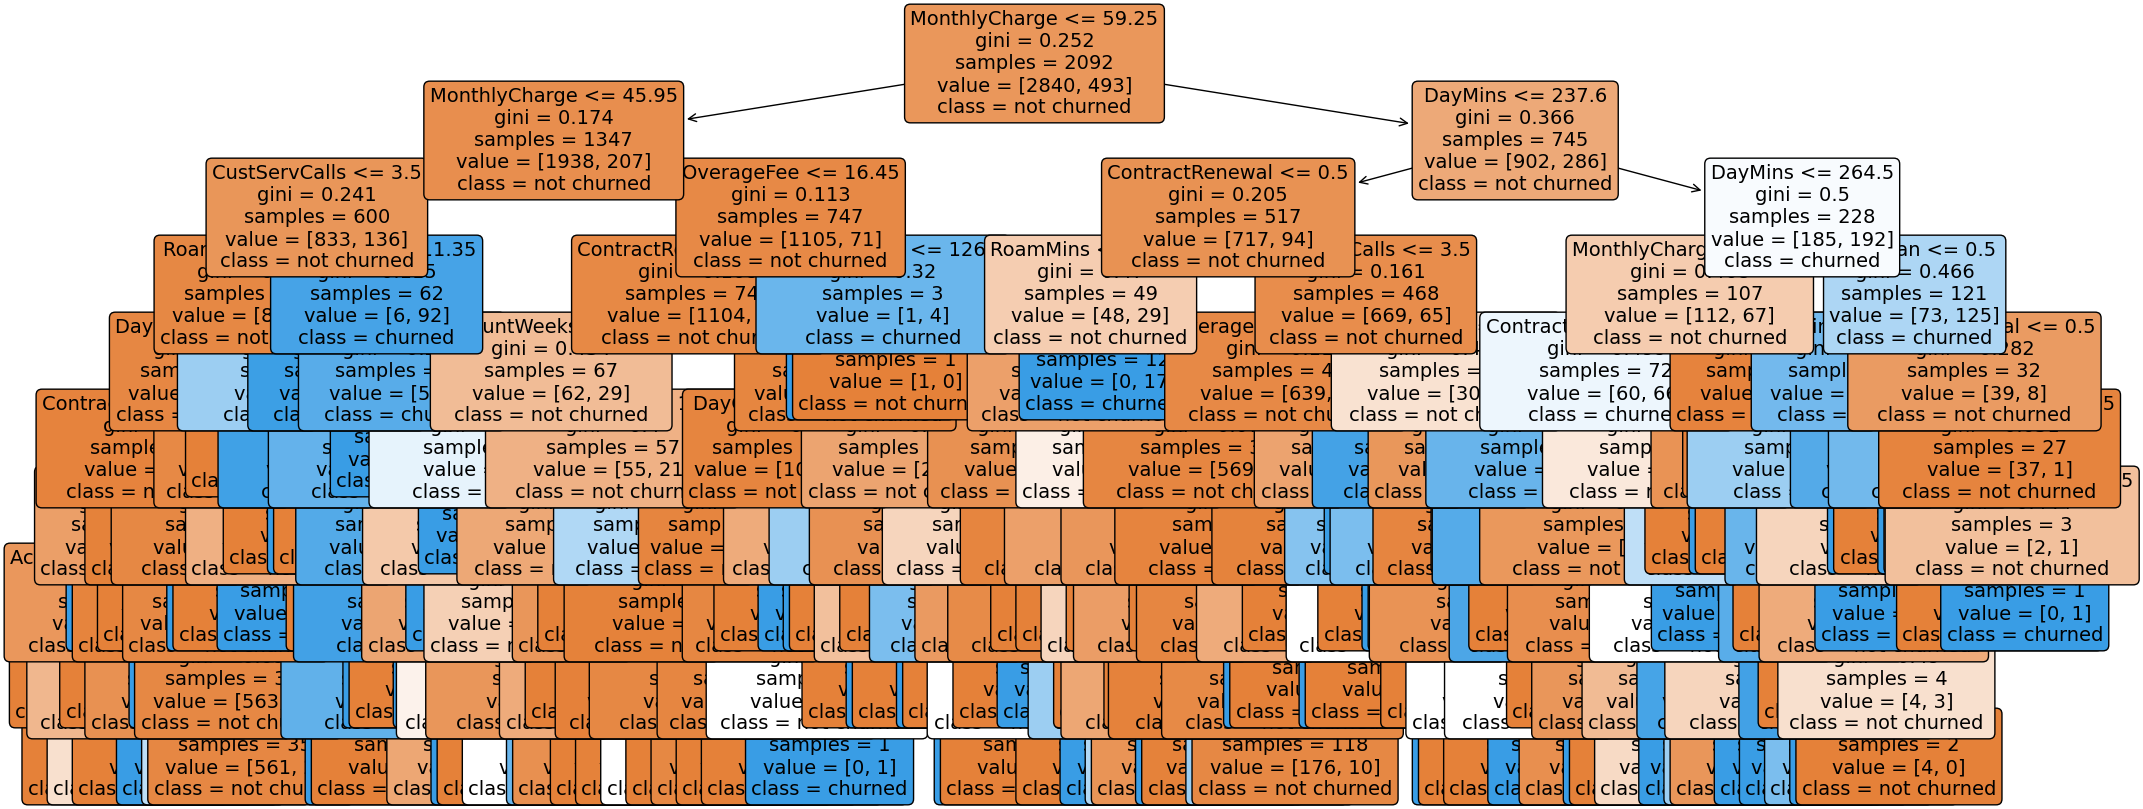

In [20]:
# Extract single tree
estimator = rf.estimators_[1]

plt.figure(figsize=(25,10))
plot_cancer = plot_tree(estimator,
                      feature_names=X.columns.tolist(), 
                      class_names=['not churned', 'churned'], 
                      filled=True, 
                      rounded=True, 
                      fontsize=14)

## XGBoost Classifier

In [21]:
xgb_model = xgb.XGBClassifier()

# Fit ada to the training set
xgb_model.fit(X, y)

# Compute the probabilities of obtaining the positive class
y_pred_xg = xgb_model.predict(X)

In [22]:
print('AUC XGBoost: ', roc_auc_score(y, y_pred_xg))

AUC XGBoost:  0.994824016563147


In [23]:
print('Accuracy Score: ', accuracy_score(y, y_pred_xg))

Accuracy Score:  0.9984998499849985


In [24]:
print(classification_report(y, y_pred_rf))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2850
           1       0.99      0.77      0.87       483

    accuracy                           0.97      3333
   macro avg       0.98      0.89      0.92      3333
weighted avg       0.97      0.97      0.96      3333



In [25]:
print('AUC Decision Tree: ', roc_auc_score(y, y_pred_dt))
print('AUC Random Forest: ', roc_auc_score(y, y_pred_rf))
print('AUC XGBoost: ', roc_auc_score(y, y_pred_xg))

AUC Decision Tree:  0.7804511278195488
AUC Randome Forest:  0.8856020485997602
AUC XGBoost:  0.994824016563147


##### The Decision Tree (DT) model achieved an AUC score of 78%, but was outperformed by the Random Forest (RF) model by 10%. This is expected since RF includes multiple decison trees whereas DT just includes one. The highest AUC score was achieved using the XGBoost model (AUC of ~99.5%) but this performance result is only valid if we reuse the same dataset that we used to train the model, so it is not representative for other datasets. In the next step we will conduct cross validation and again measure performance to identify more realistic performance of the models

### Step 4. Assess expected accuracy using *cross-validation*

In [26]:
clf_tree = DecisionTreeClassifier(max_depth=4, random_state=1)
scores_dt = cross_val_score(clf_tree, X, y, cv=5, scoring='roc_auc')

In [27]:
rf = RandomForestClassifier(max_depth=9, random_state=0)
scores_rf = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')

In [28]:
xgb_model = xgb.XGBClassifier(n_estimators=10000, max_depth=20, eval_metric='auc')
scores_xgb = cross_val_score(xgb_model, X, y, cv=5, scoring='roc_auc')

In [29]:
print('Cross Validated AUC Decision Tree: ', scores_dt.mean())
print('Cross Validated AUC Randome Forest: ', scores_rf.mean())
print('Cross Validated AUC XGBoost: ', scores_xgb.mean())

Cross Validated AUC Decision Tree:  0.875983507415446
Cross Validated AUC Randome Forest:  0.9020912838367396
Cross Validated AUC XGBoost:  0.8809343537107374


##### Interestingly, when using cross validation, the performance of XGBoost model has dropped and the RF model now showcases the highest performance (AUC of 90.2%). When we compare the results from cross validation to the result from step 3, it seems the XGBoost model suffers from overfitting and the RF model is the most robust.

### Step 5. Tune the hyperparameters of your model

#### Considering what we have observed from the previous steps and the fact that a DT model is not as strong as a RF model, we will be dropping the DT model from our analysis. Below we conduct hyperparameter optimization for the RF and XGBoost models.

 ## Random Forest Classifier

In [30]:
# Define the dictionary 'params_rf'
param_grid = {
    'n_estimators':[100, 300, 600, 800, 1000, 1100],
    'max_features':['log2', 'auto', 'sqrt'],
    'min_samples_leaf':[2, 5, 10, 15, 20],
}

# Import GridSearchCV
from sklearn.model_selection import GridSearchCV
 
# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring='roc_auc')

# Fit the grid search to the data
grid_search_rf.fit(X, y) 

Fitting 5 folds for each of 90 candidates, totalling 450 fits


/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': ['log2', 'auto', 'sqrt'],
                         'min_samples_leaf': [2, 5, 10, 15, 20],
                         'n_estimators': [100, 300, 600, 800, 1000, 1100]},
             scoring='roc_auc', verbose=2)

In [31]:
grid_search_rf.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 100}

In [32]:
grid_search_rf.best_score_

0.9043752637607765

##### Performance of RF has increased by around 0.1% utilizing Grid Search

## XGBoost Classifier

In [33]:
# Define the dictionary 'params_rf'
param_grid = {
    'max_depth': range (4, 16, 2),
    'n_estimators': range(100, 1000, 100),
    'learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001],
    'eval_metric': ['auc']
}

# Import GridSearchCV
from sklearn.model_selection import GridSearchCV
 
# Create a based model
xgb_model = xgb.XGBClassifier()

# Instantiate the grid search model
grid_search_xgb = GridSearchCV(estimator = xgb_model, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring='roc_auc')

# Fit the grid search to the data
grid_search_xgb.fit(X, y) 

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'eval_metric': ['auc'],
                         'learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001],
                         'max_depth': range(4, 16, 2),
                         'n_estimators': range(100, 1000, 100)},
             scoring='roc_auc', verbose=2)

In [34]:
grid_search_xgb.best_params_

{'eval_metric': 'auc',
 'learning_rate': 0.005,
 'max_depth': 4,
 'n_estimators': 400}

In [35]:
grid_search_xgb.best_score_

0.9022552299993972

##### Grid Search has increased the performance of the XGBoost model. Currently, the AUC of XGBoost is 90.2% and now much closer to the RF AUC.

### Step 6. Repeat steps 4 and 5 until you find the best model possible

#### Optimization Step 4 repeat

## Random Forest Classifier

In [36]:
rf_s6 = RandomForestClassifier(max_depth=9, max_features='auto', min_samples_leaf=5, n_estimators=90, random_state=0)
scores_rf_s6 = cross_val_score(rf_s6, X, y, cv=5, scoring='roc_auc')

In [37]:
print('Cross Validated AUC Randome Forest: ', scores_rf_s6.mean())

Cross Validated AUC Randome Forest:  0.9056445559775728


## XGBoost Classifier

In [38]:
xgb_model_s6 = xgb.XGBClassifier(n_estimators=350, max_depth=4, learning_rate=0.004, eval_metric='auc')
scores_xgb_s6 = cross_val_score(xgb_model_s6, X, y, cv=5, scoring='roc_auc')

In [39]:
print('Cross Validated AUC XGBoost: ', scores_xgb_s6.mean())

Cross Validated AUC XGBoost:  0.9034834132151683


##### Let's define XGBoost linear for coefficient identification

In [40]:
xgb_model_l_s6 = xgb.XGBClassifier(n_estimators=350, learning_rate=0.004, eval_metric='auc', booster='gblinear')
scores_xgb_l_s6 = cross_val_score(xgb_model_l_s6, X, y, cv=5, scoring='roc_auc')

##### Utilizing the derived information about the optimal hyperparameters, the performance of our RF and XGBoost models has improved. 

#### Grid Search Optimization Step 5 repeat

## Random Forest Classifier

##### Now let's narrow down the parameter grid to the values identified in previous run for hyperparameter tuning step 5. Fine-tuned hyperparameters identified for RF were {'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 100}

In [41]:
# Define the dictionary 'params_rf'
param_grid = {
    'n_estimators':[50, 60, 70, 80, 90, 100, 110, 120, 130],
    'max_features':['log2', 'auto', 'sqrt'],
    'min_samples_leaf':[5, 7, 8, 9, 10, 11, 12, 13, 14, 15],
}
 
# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search_rf_s6 = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring='roc_auc')

# Fit the grid search to the data
grid_search_rf_s6.fit(X, y) 

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
[CV] END max_features=log2, min_samples_leaf=2, n_estimators=300; total time=   0.8s
[CV] END max_features=log2, min_samples_leaf=2, n_estimators=600; total time=   1.7s
[CV] END max_features=log2, min_samples_leaf=2, n_estimators=1000; total time=   2.8s
[CV] END max_features=log2, min_samples_leaf=2, n_estimators=1100; total time=   3.1s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=800; total time=   2.1s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=1100; total time=   2.9s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=300; total time=   0.8s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=800; total time=   2.0s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=1000; total time=   2.5s
[CV] END max_features=log2, min_samples_leaf=15, n_estimators=100; total time=   0.2s
[CV] END max_features=log2, min_samples_leaf=15, n_estimators=100; total time=

[CV] END eval_metric=auc, learning_rate=0.05, max_depth=10, n_estimators=400; total time=   1.4s
[CV] END eval_metric=auc, learning_rate=0.05, max_depth=10, n_estimators=600; total time=   2.0s
[CV] END eval_metric=auc, learning_rate=0.05, max_depth=10, n_estimators=700; total time=   2.4s
[CV] END eval_metric=auc, learning_rate=0.05, max_depth=10, n_estimators=900; total time=   2.9s
[CV] END eval_metric=auc, learning_rate=0.05, max_depth=12, n_estimators=300; total time=   1.2s
[CV] END eval_metric=auc, learning_rate=0.05, max_depth=12, n_estimators=400; total time=   1.6s
[CV] END eval_metric=auc, learning_rate=0.05, max_depth=12, n_estimators=600; total time=   2.2s
[CV] END eval_metric=auc, learning_rate=0.05, max_depth=12, n_estimators=800; total time=   2.7s
[CV] END eval_metric=auc, learning_rate=0.05, max_depth=12, n_estimators=900; total time=   3.0s
[CV] END eval_metric=auc, learning_rate=0.05, max_depth=14, n_estimators=400; total time=   1.7s
[CV] END eval_metric=auc, lear

[CV] END eval_metric=auc, learning_rate=0.01, max_depth=12, n_estimators=900; total time=   3.9s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=14, n_estimators=400; total time=   1.7s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=14, n_estimators=500; total time=   2.3s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=14, n_estimators=700; total time=   3.1s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=14, n_estimators=900; total time=   4.2s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=4, n_estimators=400; total time=   0.5s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=4, n_estimators=500; total time=   0.7s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=4, n_estimators=600; total time=   0.8s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=4, n_estimators=800; total time=   1.1s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=4, n_estimators=900; total time=   1.2s
[CV] END eval_metric=auc, lear

[CV] END eval_metric=auc, learning_rate=0.01, max_depth=14, n_estimators=100; total time=   0.3s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=14, n_estimators=200; total time=   0.8s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=14, n_estimators=200; total time=   0.8s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=14, n_estimators=400; total time=   1.7s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=14, n_estimators=500; total time=   2.2s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=14, n_estimators=700; total time=   3.1s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=14, n_estimators=800; total time=   3.9s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=4, n_estimators=200; total time=   0.3s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=4, n_estimators=300; total time=   0.4s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=4, n_estimators=400; total time=   0.5s
[CV] END eval_metric=auc, lear

[CV] END max_features=log2, min_samples_leaf=2, n_estimators=300; total time=   0.8s
[CV] END max_features=log2, min_samples_leaf=2, n_estimators=600; total time=   1.7s
[CV] END max_features=log2, min_samples_leaf=2, n_estimators=1000; total time=   3.0s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=100; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=100; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=100; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=300; total time=   0.8s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=600; total time=   1.6s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=800; total time=   2.2s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=1100; total time=   2.9s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=600; total time=   1.5s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=

/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


in_samples_leaf=5, n_estimators=1000; total time=   2.9s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=100; total time=   0.3s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=100; total time=   0.3s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=100; total time=   0.3s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=300; total time=   0.8s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=300; total time=   0.8s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=800; total time=   2.2s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=1000; total time=   2.7s
[CV] END max_features=auto, min_samples_leaf=15, n_estimators=100; total time=   0.3s
[CV] END max_features=auto, min_samples_leaf=15, n_estimators=300; total time=   0.8s
[CV] END max_features=auto, min_samples_leaf=15, n_estimators=600; total time=   1.6s
[CV] END max_features=auto, min_samples_leaf=15, n_estimators=800; total time=   2

/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

.1s
[CV] END max_features=auto, min_samples_leaf=15, n_estimators=1100; total time=   2.7s
[CV] END max_features=auto, min_samples_leaf=20, n_estimators=600; total time=   1.4s
[CV] END max_features=auto, min_samples_leaf=20, n_estimators=1000; total time=   2.4s
[CV] END max_features=sqrt, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=2, n_estimators=300; total time=   0.8s
[CV] END max_features=sqrt, min_samples_leaf=2, n_estimators=600; total time=   1.7s
[CV] END max_features=sqrt, min_samples_leaf=2, n_estimators=1000; total time=   2.7s
[CV] END max_features=sqrt, min_samples_leaf=2, n_estimators=1100; total time=   3.1s
[CV] END max_features=sqrt, min_samples_leaf=5, n_esti

 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/C

mators=800; total time=   2.1s
[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=1100; total time=   2.9s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=300; total time=   0.8s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=600; total time=   1.5s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=1000; total time=   2.5s
[CV] END max_features=sqrt, min_samples_leaf=15, n_estimators=100; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=15, n_estimators=100; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=15, n_estimators=100; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=15, n_estimators=100; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=15, n_estimators=300; total time=   0.7s
[CV] END max_features=sqrt, min_samples_leaf=15, n_estimators=300; total time=   0.7s
[CV] END max_features=sqrt, min_samples_leaf=15, n_estimators=800; total time=   1.9s
[CV] END max_features=

askroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep t

al time=   1.6s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=8, n_estimators=800; total time=   2.0s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=8, n_estimators=900; total time=   2.2s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=10, n_estimators=400; total time=   1.3s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=10, n_estimators=500; total time=   1.5s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=10, n_estimators=700; total time=   2.0s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=10, n_estimators=900; total time=   2.4s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=12, n_estimators=200; total time=   0.8s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=12, n_estimators=300; total time=   1.1s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=12, n_estimators=400; total time=   1.3s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=12, n_estimators=600; total time=   1.7s
[CV] END eval_metric=auc, 

set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/li

eval_metric=auc, learning_rate=0.05, max_depth=10, n_estimators=500; total time=   1.7s
[CV] END eval_metric=auc, learning_rate=0.05, max_depth=10, n_estimators=700; total time=   2.3s
[CV] END eval_metric=auc, learning_rate=0.05, max_depth=10, n_estimators=800; total time=   2.8s
[CV] END eval_metric=auc, learning_rate=0.05, max_depth=12, n_estimators=200; total time=   0.8s
[CV] END eval_metric=auc, learning_rate=0.05, max_depth=12, n_estimators=300; total time=   1.2s
[CV] END eval_metric=auc, learning_rate=0.05, max_depth=12, n_estimators=400; total time=   1.6s
[CV] END eval_metric=auc, learning_rate=0.05, max_depth=12, n_estimators=600; total time=   2.1s
[CV] END eval_metric=auc, learning_rate=0.05, max_depth=12, n_estimators=700; total time=   2.5s
[CV] END eval_metric=auc, learning_rate=0.05, max_depth=12, n_estimators=900; total time=   2.9s
[CV] END eval_metric=auc, learning_rate=0.05, max_depth=14, n_estimators=300; total time=   1.3s
[CV] END eval_metric=auc, learning_rate

emove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/skl

etric=auc, learning_rate=0.01, max_depth=12, n_estimators=200; total time=   0.7s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=12, n_estimators=300; total time=   1.1s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=12, n_estimators=400; total time=   1.7s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=12, n_estimators=600; total time=   2.5s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=12, n_estimators=700; total time=   3.1s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=12, n_estimators=900; total time=   3.8s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=14, n_estimators=300; total time=   1.3s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=14, n_estimators=500; total time=   2.2s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=14, n_estimators=600; total time=   2.8s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=14, n_estimators=800; total time=   3.7s
[CV] END eval_metric=auc, learning_rate=0.005

forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

ples_leaf=10, n_estimators=100; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=300; total time=   0.7s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=600; total time=   1.5s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=800; total time=   2.0s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=1100; total time=   2.7s
[CV] END max_features=log2, min_samples_leaf=15, n_estimators=600; total time=   1.6s
[CV] END max_features=log2, min_samples_leaf=15, n_estimators=1000; total time=   2.7s
[CV] END max_features=log2, min_samples_leaf=15, n_estimators=1100; total time=   2.9s
[CV] END max_features=log2, min_samples_leaf=20, n_estimators=800; total time=   1.9s
[CV] END max_features=log2, min_samples_leaf=20, n_estimators=1000; total time=   2.3s
[CV] END max_features=auto, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END max_features=auto, min_samples_leaf=2, n_estimators=300; total time=   0.9s
[

  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be re

s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=10, n_estimators=900; total time=   3.4s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=12, n_estimators=400; total time=   1.6s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=12, n_estimators=500; total time=   2.2s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=12, n_estimators=700; total time=   3.0s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=12, n_estimators=900; total time=   3.9s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=14, n_estimators=200; total time=   0.8s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=14, n_estimators=300; total time=   1.2s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=14, n_estimators=500; total time=   2.2s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=14, n_estimators=600; total time=   2.7s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=14, n_estimators=800; total time=   3.6s
[CV] END eval_metric=auc, le

domForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='

ures=auto, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END max_features=auto, min_samples_leaf=2, n_estimators=300; total time=   0.9s
[CV] END max_features=auto, min_samples_leaf=2, n_estimators=300; total time=   0.8s
[CV] END max_features=auto, min_samples_leaf=2, n_estimators=800; total time=   2.3s
[CV] END max_features=auto, min_samples_leaf=2, n_estimators=1100; total time=   3.1s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=300; total time=   0.8s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=600; total time=   1.6s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=1000; total time=   2.8s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=1100; total time=   3.1s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=800; total time=   2.1s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=1000; total time=   2.7s
[CV] END max_features=auto, min_samples_leaf=15, n_estimators=300; total tim

s.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be

/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': ['log2', 'auto', 'sqrt'],
                         'min_samples_leaf': [5, 7, 8, 9, 10, 11, 12, 13, 14,
                                              15],
                         'n_estimators': [50, 60, 70, 80, 90, 100, 110, 120,
                                          130]},
             scoring='roc_auc', verbose=2)

In [42]:
grid_search_rf_s6.best_params_

{'max_features': 'log2', 'min_samples_leaf': 8, 'n_estimators': 50}

In [43]:
grid_search_rf_s6.best_score_

0.9059444519804666

##### After narrowing down Grid Search for the RF model we have achieved a performace increase of 0.2%, raising the overall score to higher 90.5%

## XGBoost Classifier

##### Let's try to optimize more XGBoost Grid Search from optimal hyperparameters found in step 5 {'eval_metric': 'auc', 'learning_rate': 0.005, 'max_depth': 4, 'n_estimators': 400}

In [44]:
# Define the dictionary 'params_rf'
param_grid = {
    'max_depth': range (4, 16, 2),
    'n_estimators': range(300, 500, 25),
    'learning_rate': [ 0.01, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002, 0.001],
    'eval_metric': ['auc']
}
 
# Create a based model
xgb_model = xgb.XGBClassifier()

# Instantiate the grid search model
grid_search_xgb_s6 = GridSearchCV(estimator = xgb_model, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring='roc_auc')

# Fit the grid search to the data
grid_search_xgb_s6.fit(X, y) 

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=10, n_estimators=500; total time=   1.8s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=10, n_estimators=700; total time=   2.5s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=10, n_estimators=800; total time=   3.1s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=12, n_estimators=200; total time=   0.6s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=12, n_estimators=200; total time=   0.7s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=12, n_estimators=300; total time=   1.1s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=12, n_estimators=500; total time=   2.0s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=12, n_estimators=600; total time=   2.5s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=12, n_estimators=800; total time=   3.3s
[CV] END eval_metric=auc, learning_rate=0.005, max_dep

[CV] END eval_metric=auc, learning_rate=0.005, max_depth=8, n_estimators=500; total time=   1.5s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=8, n_estimators=600; total time=   1.8s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=8, n_estimators=800; total time=   2.4s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=10, n_estimators=100; total time=   0.3s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=10, n_estimators=100; total time=   0.3s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=10, n_estimators=100; total time=   0.3s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=10, n_estimators=200; total time=   0.6s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=10, n_estimators=300; total time=   0.9s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=10, n_estimators=400; total time=   1.4s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=10, n_estimators=600; total time=   2.1s
[CV] END eval_metric=au

[CV] END max_features=sqrt, min_samples_leaf=7, n_estimators=120; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=8, n_estimators=60; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=8, n_estimators=60; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=8, n_estimators=80; total time=   0.2s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=4, n_estimators=800; total time=   1.1s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=4, n_estimators=900; total time=   1.2s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=6, n_estimators=400; total time=   0.9s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=6, n_estimators=500; total time=   1.1s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=6, n_estimators=700; total time=   1.7s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=6, n_estimators=900; total time=   2.0s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=8, n_estimators=200; tot

[CV] END eval_metric=auc, learning_rate=0.005, max_depth=10, n_estimators=800; total time=   3.0s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=12, n_estimators=100; total time=   0.3s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=12, n_estimators=100; total time=   0.3s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=12, n_estimators=100; total time=   0.3s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=12, n_estimators=200; total time=   0.7s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=12, n_estimators=300; total time=   1.0s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=12, n_estimators=400; total time=   1.5s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=12, n_estimators=500; total time=   2.1s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=12, n_estimators=700; total time=   2.9s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=12, n_estimators=900; total time=   3.8s
[CV] END eval_metric

[CV] END max_features=log2, min_samples_leaf=14, n_estimators=70; total time=   0.2s
[CV] END max_features=log2, min_samples_leaf=14, n_estimators=100; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=14, n_estimators=100; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=14, n_estimators=130; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=14, n_estimators=130; total time=   0.4s
[CV] END max_features=log2, min_samples_leaf=15, n_estimators=90; total time=   0.2s
[CV] END max_features=log2, min_samples_leaf=15, n_estimators=90; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=15, n_estimators=120; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=15, n_estimators=120; total time=   0.3s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=70; total time=   0.2s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=70; total time=   0.2s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=

[CV] END max_features=log2, min_samples_leaf=13, n_estimators=90; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=13, n_estimators=90; total time=   0.2s
[CV] END max_features=log2, min_samples_leaf=13, n_estimators=120; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=13, n_estimators=120; total time=   0.4s
[CV] END max_features=log2, min_samples_leaf=14, n_estimators=70; total time=   0.2s
[CV] END max_features=log2, min_samples_leaf=14, n_estimators=70; total time=   0.2s
[CV] END max_features=log2, min_samples_leaf=14, n_estimators=100; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=14, n_estimators=100; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=14, n_estimators=130; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=15, n_estimators=50; total time=   0.1s
[CV] END max_features=log2, min_samples_leaf=15, n_estimators=80; total time=   0.2s
[CV] END max_features=log2, min_samples_leaf=15, n_estimator

[CV] END eval_metric=auc, learning_rate=0.005, max_depth=8, n_estimators=300; total time=   0.9s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=8, n_estimators=400; total time=   1.1s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=8, n_estimators=600; total time=   1.8s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=8, n_estimators=700; total time=   2.1s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=8, n_estimators=900; total time=   2.7s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=10, n_estimators=300; total time=   1.0s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=10, n_estimators=500; total time=   1.8s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=10, n_estimators=700; total time=   2.6s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=10, n_estimators=800; total time=   3.1s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=12, n_estimators=100; total time=   0.3s
[CV] END eval_metric=auc,

[CV] END eval_metric=auc, learning_rate=0.005, max_depth=10, n_estimators=400; total time=   1.4s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=10, n_estimators=600; total time=   2.2s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=10, n_estimators=800; total time=   2.9s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=10, n_estimators=900; total time=   3.4s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=12, n_estimators=400; total time=   1.5s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=12, n_estimators=600; total time=   2.4s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=12, n_estimators=700; total time=   2.9s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=12, n_estimators=900; total time=   3.7s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=14, n_estimators=300; total time=   1.0s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=14, n_estimators=400; total time=   1.6s
[CV] END eval_metric

[CV] END eval_metric=auc, learning_rate=0.005, max_depth=14, n_estimators=900; total time=   3.9s
[CV] END eval_metric=auc, learning_rate=0.001, max_depth=4, n_estimators=400; total time=   0.5s
[CV] END eval_metric=auc, learning_rate=0.001, max_depth=4, n_estimators=500; total time=   0.7s
[CV] END eval_metric=auc, learning_rate=0.001, max_depth=4, n_estimators=700; total time=   1.0s
[CV] END eval_metric=auc, learning_rate=0.001, max_depth=4, n_estimators=800; total time=   1.1s
[CV] END eval_metric=auc, learning_rate=0.001, max_depth=6, n_estimators=100; total time=   0.2s
[CV] END eval_metric=auc, learning_rate=0.001, max_depth=6, n_estimators=200; total time=   0.4s
[CV] END eval_metric=auc, learning_rate=0.001, max_depth=6, n_estimators=300; total time=   0.6s
[CV] END eval_metric=auc, learning_rate=0.001, max_depth=6, n_estimators=400; total time=   0.9s
[CV] END eval_metric=auc, learning_rate=0.001, max_depth=6, n_estimators=600; total time=   1.3s
[CV] END eval_metric=auc, lea

[CV] END max_features=sqrt, min_samples_leaf=7, n_estimators=70; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=7, n_estimators=100; total time=   0.4s
[CV] END max_features=sqrt, min_samples_leaf=7, n_estimators=100; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=8, n_estimators=50; total time=   0.1s
[CV] END max_features=sqrt, min_samples_leaf=8, n_estimators=50; total time=   0.1s
[CV] END max_features=sqrt, min_samples_leaf=8, n_estimators=50; total time=   0.1s
[CV] END max_features=sqrt, min_samples_leaf=8, n_estimators=60; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=8, n_estimators=80; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=8, n_estimators=80; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=8, n_estimators=110; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=8, n_estimators=110; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=9, n_estimators=50; total t

[CV] END max_features=sqrt, min_samples_leaf=8, n_estimators=80; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=8, n_estimators=110; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=8, n_estimators=120; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=9, n_estimators=60; total time=   0.1s
[CV] END max_features=sqrt, min_samples_leaf=9, n_estimators=60; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=9, n_estimators=80; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=9, n_estimators=90; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=9, n_estimators=120; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=9, n_estimators=120; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=60; total time=   0.1s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=60; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=90; tota

[CV] END max_features=sqrt, min_samples_leaf=8, n_estimators=120; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=9, n_estimators=60; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=9, n_estimators=60; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=9, n_estimators=90; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=9, n_estimators=90; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=9, n_estimators=120; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=9, n_estimators=130; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=70; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=80; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=110; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=110; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=11, n_estimators=50; t

[CV] END max_features=sqrt, min_samples_leaf=9, n_estimators=100; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=9, n_estimators=130; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=9, n_estimators=130; total time=   0.4s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=90; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=100; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=130; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=130; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=11, n_estimators=80; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=11, n_estimators=80; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=11, n_estimators=110; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=11, n_estimators=110; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=12, n_estimator

[CV] END eval_metric=auc, learning_rate=0.005, max_depth=4, n_estimators=475; total time=   0.6s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=6, n_estimators=300; total time=   0.6s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=6, n_estimators=350; total time=   0.7s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=6, n_estimators=375; total time=   0.8s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=6, n_estimators=425; total time=   0.9s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=6, n_estimators=475; total time=   1.0s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=8, n_estimators=300; total time=   0.9s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=8, n_estimators=350; total time=   1.0s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=8, n_estimators=375; total time=   1.1s
[CV] END eval_metric=auc, learning_rate=0.005, max_depth=8, n_estimators=425; total time=   1.2s
[CV] END eval_metric=auc, lear

[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=60; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=60; total time=   0.1s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=90; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=90; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=120; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=120; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=11, n_estimators=70; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=11, n_estimators=70; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=11, n_estimators=100; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=11, n_estimators=100; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=11, n_estimators=130; total time=   0.4s
[CV] END max_features=sqrt, min_samples_leaf=11, n_estimator

[CV] END max_features=sqrt, min_samples_leaf=11, n_estimators=90; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=11, n_estimators=120; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=11, n_estimators=120; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=12, n_estimators=70; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=12, n_estimators=70; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=12, n_estimators=100; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=12, n_estimators=100; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=12, n_estimators=130; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=12, n_estimators=130; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=13, n_estimators=80; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=13, n_estimators=90; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=13, n_estimato

[CV] END max_features=sqrt, min_samples_leaf=13, n_estimators=90; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=13, n_estimators=90; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=13, n_estimators=120; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=13, n_estimators=120; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=14, n_estimators=70; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=14, n_estimators=70; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=14, n_estimators=100; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=14, n_estimators=100; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=14, n_estimators=130; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=15, n_estimators=50; total time=   0.1s
[CV] END max_features=sqrt, min_samples_leaf=15, n_estimators=60; total time=   0.1s
[CV] END max_features=sqrt, min_samples_leaf=15, n_estimator

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'eval_metric': ['auc'],
                         'learning_rate': [0.01, 0.008, 0.007, 0.006, 0.005,
                                           0.004, 0.003, 0.002, 0.001],
                         'max_depth': range(4, 16, 2),
                         'n_estimators': range(300, 500, 25)},
             scoring='roc_auc', verbose=2)

In [45]:
grid_search_xgb_s6.best_params_

{'eval_metric': 'auc',
 'learning_rate': 0.004,
 'max_depth': 4,
 'n_estimators': 350}

In [46]:
grid_search_xgb_s6.best_score_

0.9034834132151683

##### Again, narrowing down the hyperparameter ranges has helped. The AUC of our XGBoost model has improved by 0.1%

### 7. Answer the questions asked

### **1. What variables are contributing to customer churn?** 

## Random Forest Classifier

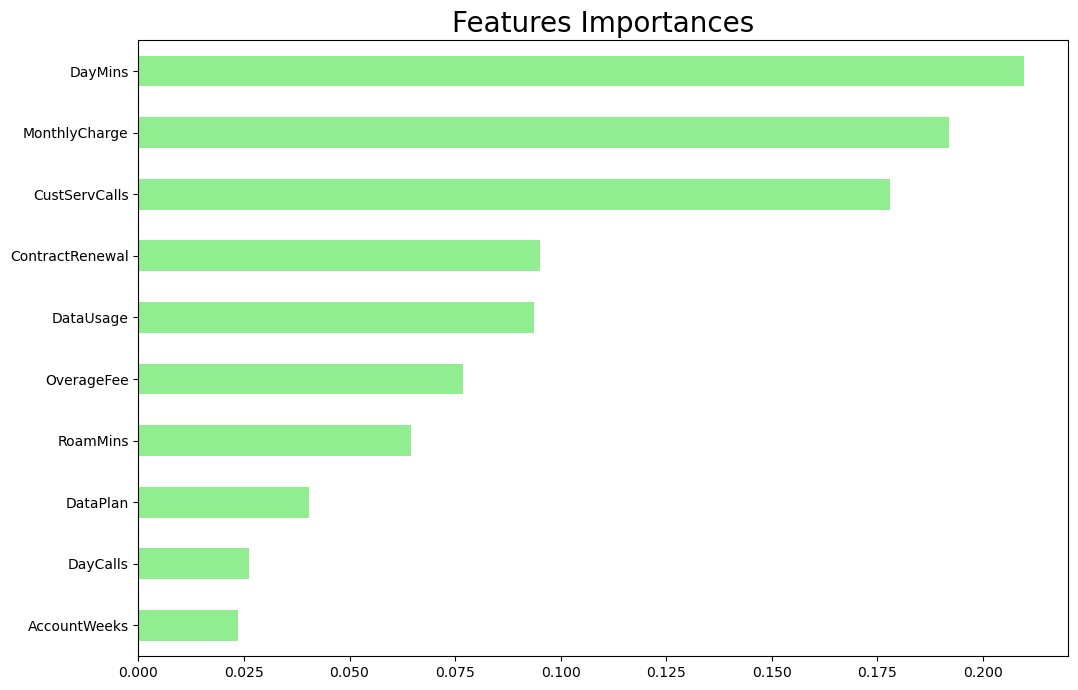

In [47]:
rf_s6_f = rf_s6.fit(X, y)
# Create a pd.Series of features importances
importances = pd.Series(data=rf_s6_f.feature_importances_,
                        index= X.columns.tolist())
 
# Sort importances
importances_sorted = importances.sort_values()
 

# Draw a horizontal barplot of importances_sorted
plt.figure(figsize=(12,8))
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances', size=20)
plt.show()

In [56]:
importances = rf_s6_f.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_s6_f.estimators_], axis=0)

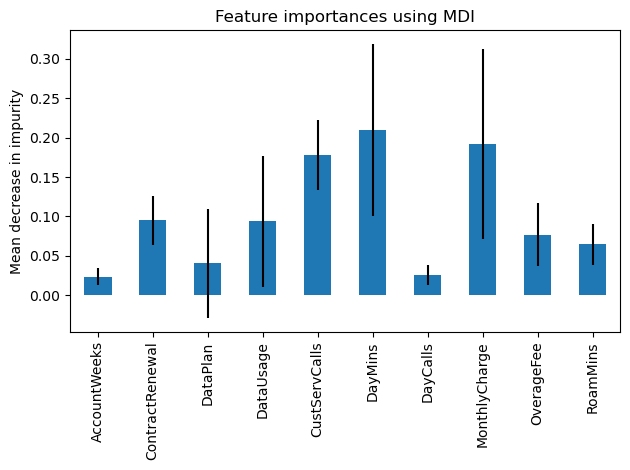

In [58]:
forest_importances = pd.Series(importances, index=X.columns.tolist())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## XGBoost Classifier

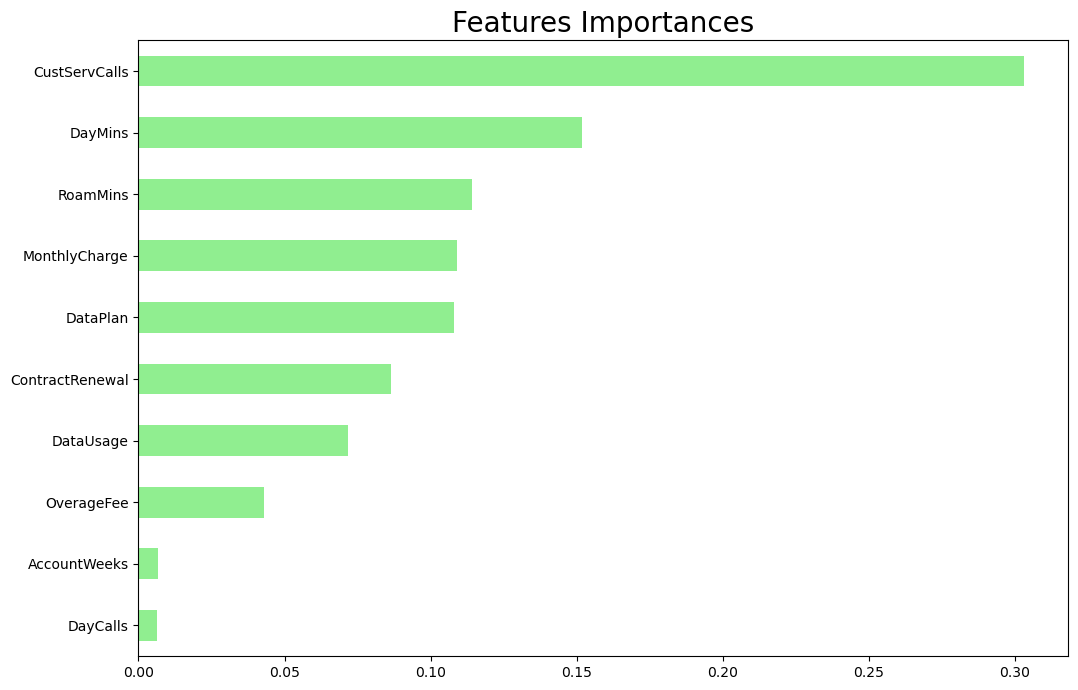

In [48]:
xgb_model_s6_f = xgb_model_s6.fit(X, y)
# Create a pd.Series of features importances
importances = pd.Series(data=xgb_model_s6_f.feature_importances_,
                        index= X.columns.tolist())
 
# Sort importances
importances_sorted = importances.sort_values()
 
# Draw a horizontal barplot of importances_sorted
plt.figure(figsize=(12,8))
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances', size=20)
plt.show()


##### The top three most important features in the RF model are average daytime minutes per month, average monthly charge, and number of calls to customer service (respectively ranked)

##### The top three most important features in the XGBoost model are number of calls to customer service, average daytime minutes per month, and number of roaming minutes (respectively ranked)

##### Using the feature importance information of both models, we can state with certainty that the number of customer service calls and average daytime minutes per month have the highest impact on customer churn.

##### Average monthly bill and average number of roaming minutes also seem to have a substantial impact on customer churn


### **2. Who are the customers more likely to churn?**

##### To understand which customers are more likely to churn, we need to develop an understanding of how our model uses each feature to asses the probability of churning. We need to understand if the feature increases the likelihood of churning or decreases it.

##### To start understanding this, we visualize some of the decision trees in our random forest, the tree rules, and model decision path for cusomters in our dataset.

## Random Forest Classifier

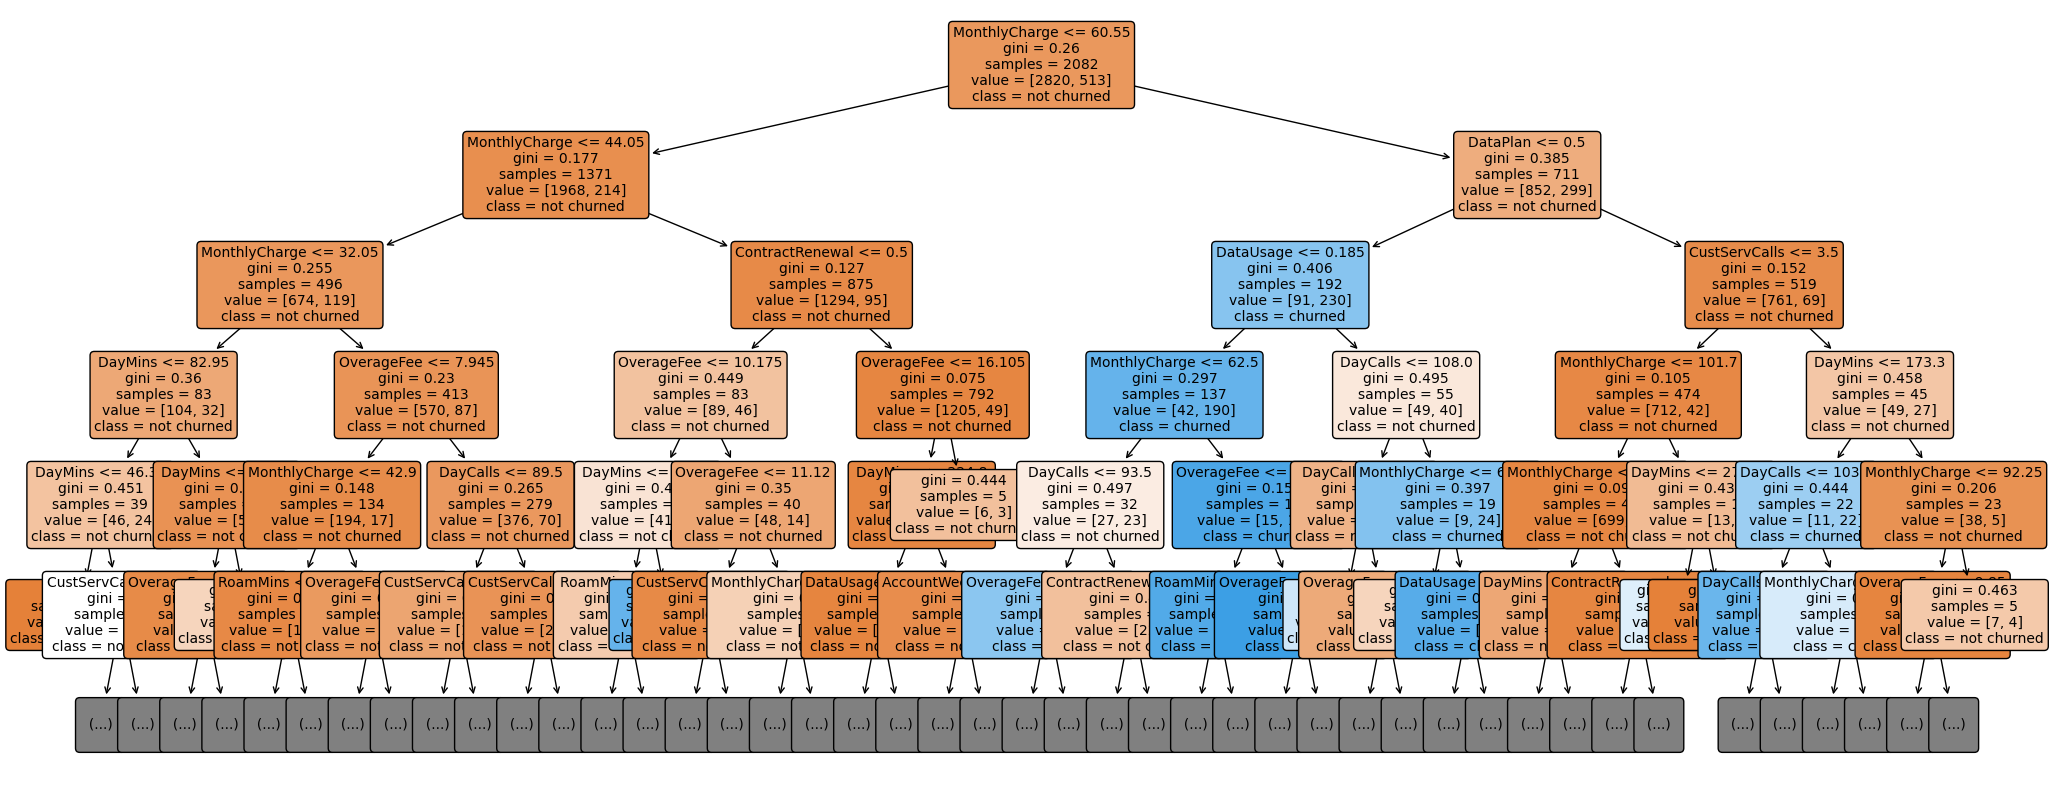

In [159]:
# Visualizing a single trees (replace the index number to visualize)
estimator = rf_s6.estimators_[67]

plt.figure(figsize=(25,10))
plot_cancer = plot_tree(estimator,
                      feature_names=X.columns.tolist(), 
                      class_names=['not churned', 'churned'], 
                      filled=True, 
                      rounded=True, 
                      fontsize=10,
                      max_depth=5)

In [50]:
# review tree rules
tree_rules = export_text(rf_s6.estimators_[2], feature_names=list(X.columns),  max_depth=3, show_weights=True)

In [51]:
print(tree_rules)

|--- DayMins <= 261.35
|   |--- MonthlyCharge <= 45.95
|   |   |--- ContractRenewal <= 0.50
|   |   |   |--- CustServCalls <= 3.50
|   |   |   |   |--- truncated branch of depth 6
|   |   |   |--- CustServCalls >  3.50
|   |   |   |   |--- weights: [0.00, 15.00] class: 1.0
|   |   |--- ContractRenewal >  0.50
|   |   |   |--- MonthlyCharge <= 22.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- MonthlyCharge >  22.50
|   |   |   |   |--- truncated branch of depth 6
|   |--- MonthlyCharge >  45.95
|   |   |--- MonthlyCharge <= 59.25
|   |   |   |--- RoamMins <= 9.05
|   |   |   |   |--- truncated branch of depth 6
|   |   |   |--- RoamMins >  9.05
|   |   |   |   |--- truncated branch of depth 6
|   |   |--- MonthlyCharge >  59.25
|   |   |   |--- ContractRenewal <= 0.50
|   |   |   |   |--- truncated branch of depth 6
|   |   |   |--- ContractRenewal >  0.50
|   |   |   |   |--- truncated branch of depth 6
|--- DayMins >  261.35
|   |--- DataUsage <= 0.33
|   |   |--

In [150]:
# split the data into the entries that the model predicted would churn and wouldn't churn
probas = rf_s6.estimators_[2].predict_proba(X)
X['predictions'] = probas[:,1]
predictedchurn = list(X[X['predictions'] == 1].index)
predictednochurn = list(X[X['predictions'] == 0].index)
X.drop('predictions', inplace = True, axis = 1)

In [115]:
node_indicator = rf_s6.estimators_[2].decision_path(X)
leaf_id = rf_s6.estimators_[2].apply(X)

# visualization of the path of 5 random customers that churned
for ids in random.sample(predictedchurn, 5):
    sample_id = ids
    # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
    node_index = node_indicator.indices[
        node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
    ]
    print("\nRules used to predict sample {id} - a customer that churned:\n".format(id=sample_id))
    for node_id in node_index:
        # continue to the next node if it is a leaf node
        if leaf_id[sample_id] == node_id:
            continue
        # check if value of the split feature for sample 0 is below threshold
        if X.loc[sample_id, X.columns[feature[node_id]]] <= threshold[node_id]:
            threshold_sign = "<="
        else:
            threshold_sign = ">"
        print(X.columns[feature[node_id]])
        print(
            "decision node {node} : (X[{sample}, {feature}] = {value}) "
            "{inequality} {threshold})".format(
                node=node_id,
                sample=sample_id,
                feature=feature[node_id],
                value=X.loc[sample_id, X.columns[feature[node_id]]],
                inequality=threshold_sign,
                threshold=threshold[node_id],
            )
        )

# visualization of the path of 5 random customers that didn't churn        
for ids in random.sample(predictednochurn, 5):
    sample_id = ids
    # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
    node_index = node_indicator.indices[
        node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
    ]
    print("\nRules used to predict sample {id} a customer that didn't churn:\n".format(id=sample_id))
    for node_id in node_index:
        # continue to the next node if it is a leaf node
        if leaf_id[sample_id] == node_id:
            continue
        # check if value of the split feature for sample 0 is below threshold
        if X.loc[sample_id, X.columns[feature[node_id]]] <= threshold[node_id]:
            threshold_sign = "<="
        else:
            threshold_sign = ">"
        print(X.columns[feature[node_id]])
        print(
            "decision node {node} : (X[{sample}, {feature}] = {value}) "
            "{inequality} {threshold})".format(
                node=node_id,
                sample=sample_id,
                feature=feature[node_id],
                value=X.loc[sample_id, X.columns[feature[node_id]]],
                inequality=threshold_sign,
                threshold=threshold[node_id],
            )
        )


Rules used to predict sample 3268 - a customer that churned:

DayMins
decision node 0 : (X[3268, 5] = 289.1) > 261.34999084472656)
DataUsage
decision node 154 : (X[3268, 3] = 0.0) <= 0.32500000298023224)
RoamMins
decision node 155 : (X[3268, 9] = 12.7) > 8.25)
OverageFee
decision node 163 : (X[3268, 8] = 11.69) > 8.444999694824219)
OverageFee
decision node 167 : (X[3268, 8] = 11.69) > 9.259999752044678)
DataUsage
decision node 169 : (X[3268, 3] = 0.0) <= 0.0949999988079071)

Rules used to predict sample 2608 - a customer that churned:

DayMins
decision node 0 : (X[2608, 5] = 168.3) <= 261.34999084472656)
MonthlyCharge
decision node 1 : (X[2608, 7] = 70.1) > 45.95000076293945)
MonthlyCharge
decision node 49 : (X[2608, 7] = 70.1) > 59.25)
ContractRenewal
decision node 101 : (X[2608, 1] = 1) > 0.5)
CustServCalls
decision node 115 : (X[2608, 4] = 4) > 3.5)
DataUsage
decision node 141 : (X[2608, 3] = 1.81) <= 2.524999976158142)
DayMins
decision node 142 : (X[2608, 5] = 168.3) <= 174.75)

R

In [160]:
n_nodes = rf_s6.estimators_[2].tree_.node_count
print(f'The tree has {n_nodes} nodes')

The tree has 181 nodes


##### Above we can observe the decision paths of the second tree in our RF model. It starts dividing the dataset using DayMins (average daytime minutes per month) where it evaluates if the value in the sample is <= 261.35, if it is it goes to the left branch of the tree where proportion of customer not churned is 2774 and churned 354. When the average daytime minutes per month is > 261.35 the dominant class is churned (106 customers). Continuing through the last branch, if gigabytes of monthly data usage is <= 0.325 then customer will be more likely to churn (since the node gets divided by 101 churned vs 48 not churned). Customers who had gigabytes of monthly data usage > 0.325, are more likely to not churn.

##### Let's move to decision modes which have affected churn as a decision node which separated churned customers. One of such decision nodes is ContactRenewal <= 0.5 namely 1 if customer recently renewed contract, 0 if not and this threshold of 0.5 tells us that if customers has not renewed contract they will have much higher chances of churning as we see from child nodes to the left where condition is met proportion of not churned/ churned is 33/47, whereas in the right node overwhelming majority are not churned customers 748 vs 99. To continue, that decision route if number of calls into customer service above 3.5 there is again much higher probability of customers churning.

##### Average number of roaming minutes above 8.25 also drives churn as we can see from plot of estimator 2 above.

##### Due to the higher number of nodes and trees in a random forest model, stating a perfect formula of the feature thresholds in predicting churn is not very straightforward. However, we can analyze the values of the features in a dataset of the customers that the model predicted as likely to churn. For example, perhaps we can run an experiment and see how many times the model predicts a churn for customers with more than the most common threshold of average daytime minutes per month in the model. 

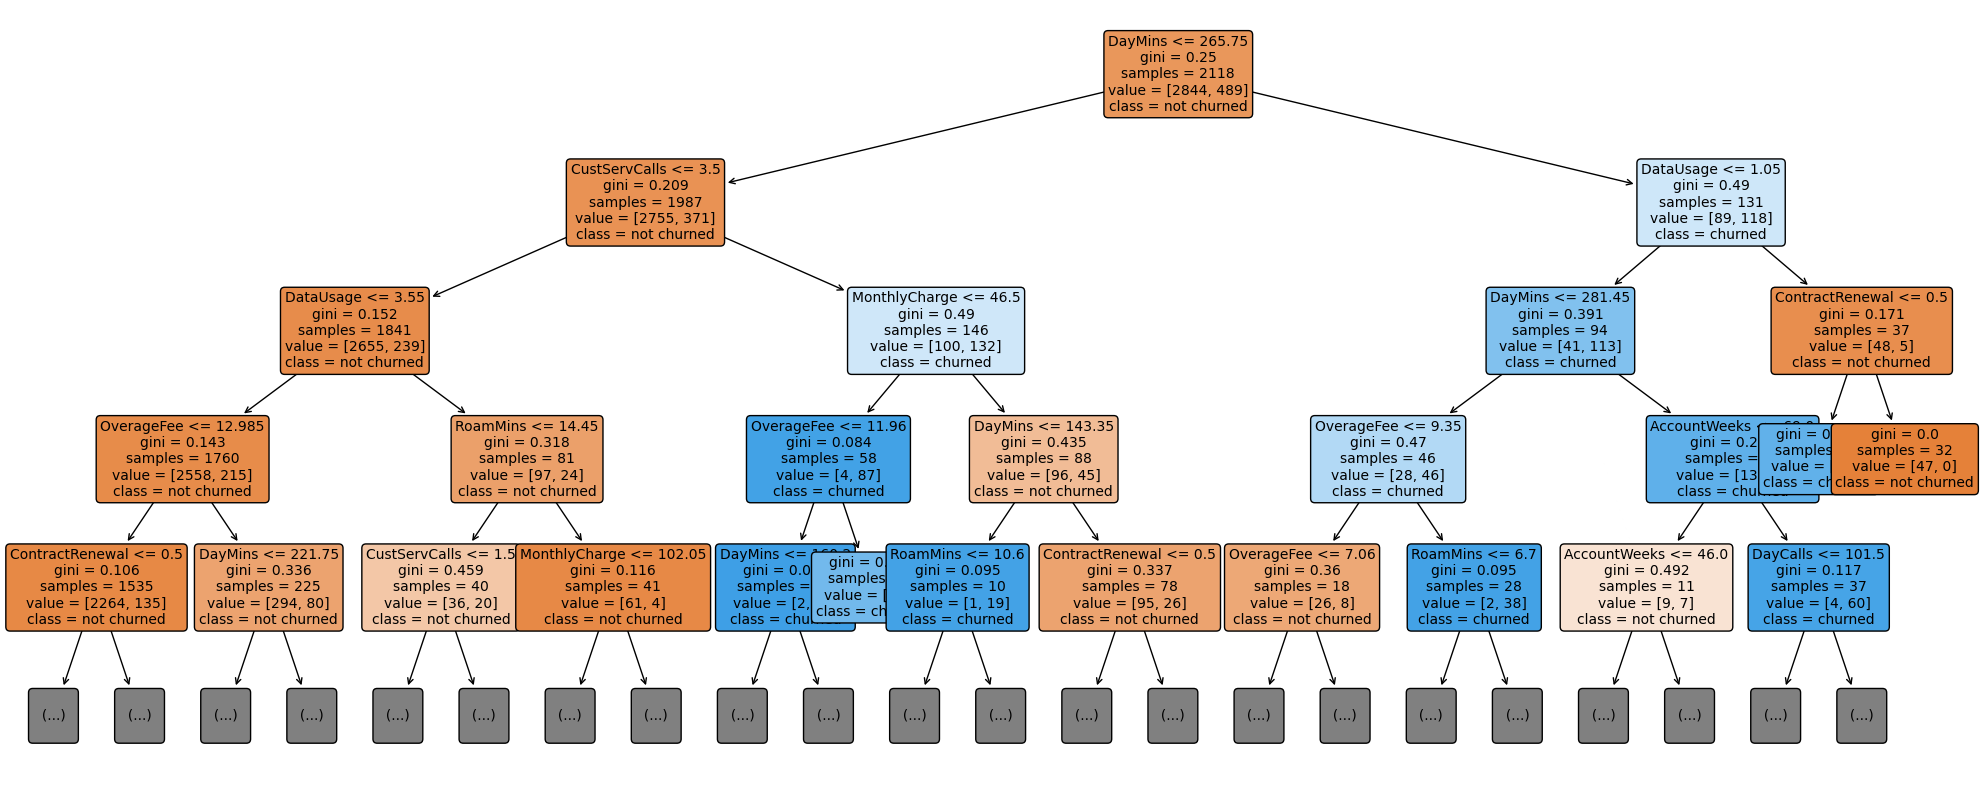

In [52]:
# Extract single tree
estimator = rf_s6.estimators_[5]

plt.figure(figsize=(25,10))
plot_cancer = plot_tree(estimator,
                      feature_names=X.columns.tolist(), 
                      class_names=['not churned', 'churned'], 
                      filled=True, 
                      rounded=True, 
                      fontsize=10,
                      max_depth=4)

##### Interestingly, if average daytime minutes per month is above 265.75 then there are much higher chances of churn. If number of calls into customer service is above 3.5 again chance of customer churning highly increases. To continue in that decision node path if average monthly bill of customer is under 46.5 then again chanches of churning increase. If gigabytes of monthly data usage is less than 1.05 cuctomer churn increases.

#### Below we visualize the coefficients from Linear XGBoost model

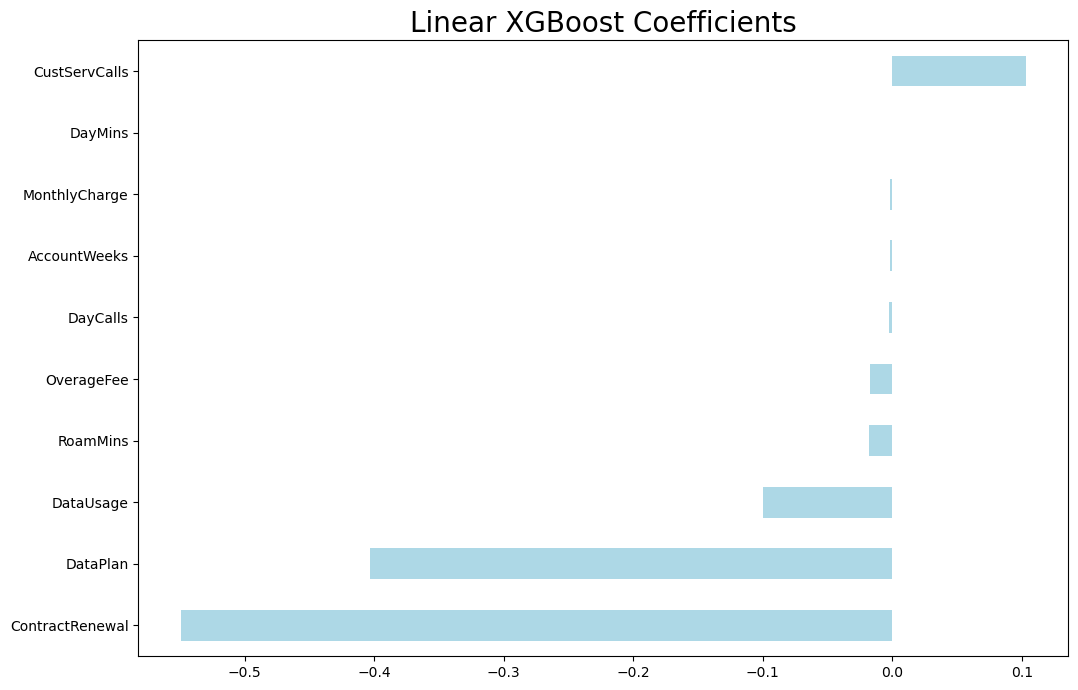

In [161]:
xgb_model_l_s6_f = xgb_model_l_s6.fit(X, y)
# Create a pd.Series of features importances
importances = pd.Series(data=xgb_model_l_s6_f.coef_,
                        index= X.columns.tolist())
 
# Sort importances
importances_sorted = importances.sort_values()
 
# Draw a horizontal barplot of importances_sorted
plt.figure(figsize=(12,8))
importances_sorted.plot(kind='barh', color='lightblue')
plt.title('Linear XGBoost Coefficients', size=20)
plt.show()

##### As we can observe from the plot above, the number of calls into customer service is the feature that has the largest impact on the customer churn. In contrast, if ContractRenewal has been reached recently chances of customer churn reduce. Having data plan also reduces chances of customer churn as well high customer who use high number of gigabytes of monthly data usage.

### **3. What actions can be taken to stop them from leaving?**

##### Based on observations above we can conclude and suggest that if a client wants to reduce customer churn they should review the issues a churned customer called into customer service for. They should prioritize solving recurring problems. 

##### Furthermore, since our Random Forest model determined the average daytime minutes per month as one of the most important features, they should review if there is a pattern in average monthly daytime minute usage over time and churn rate. For example, does the monthly daytime minute usage drop right before a customer churns within the current month? If they can identify this, then can target potential churners with a promotion to convince them to stay.

##### Based on the XGBoost model, we found there are factors that drive down customer churn, namely contract renewal recency and having a data plan. The client should increase the rate of contract renewals and cover more customers by offering promotions and beneficial terms. Additionally, the client should promote more Data Plans to their customers. 